# setup

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'

# functions

In [27]:
class MLP(nn.Module):
    def __init__(
            self,
            architecture,
            activation='relu', 
            dropout_p=None,
            use_l2=False
        ):
        """
        `todo`
        """
        super(MLP, self).__init__()
        #
        self.n_layers = len(architecture) - 1
        self.layers = nn.ModuleList()
        self.dropout = None if dropout_p is None else nn.Dropout(dropout_p)
        self.use_l2 = use_l2
        #
        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise ValueError("função de ativação deve ser 'relu' ou 'tanh'")
        #
        for i in range(self.n_layers):
            self.layers.append(
                nn.Linear(architecture[i], architecture[i+1])
            )
            #
            nn.init.normal_(self.layers[i].weight, mean=0.0, std=1)
            nn.init.zeros_(self.layers[i].bias)
    
    def forward(self, x):
        """
        `todo`
        """
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
            if self.dropout is not None:
                x = self.dropout(x)
        #
        x = self.layers[-1](x)
        return x

In [16]:
def get_loss_function(task='multiclass'):
    if task.lower() == 'binary':
        return nn.BCEWithLogitsLoss()
    elif task.lower() == 'multiclass':
        return nn.CrossEntropyLoss()
    else:
        raise ValueError("task must be 'binary' or 'multiclass'")


def get_optimizer(model, optimizer_type='sgd', lr=0.01, momentum=0.9, weight_decay=0):
    if optimizer_type.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_type.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("optimizer_type must be 'sgd' or 'adam'")


def get_output_size(y, task='binary'):
    """
    `todo`
    """
    if task.lower() == 'binary':
        return 1  # One output neuron for binary classification
    else:
        # For multiclass, return the number of unique classes
        return len(np.unique(y))

In [33]:
def train_model(
        model,
        dataloader_train,
        dataloader_val,
        criterion,
        optimizer,
        epochs=100,
        patience=20,
        device='cpu',
        l2_lambda=0.0,
        task='multiclass'
    ):
    """
    `todo`
    """
    model.to(device)
    history = {
        'train_loss': list(),
        'train_acc': list(),
        'val_loss': list(),
        'val_acc': list()
    }
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None
    #
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, targets in dataloader_train:
            inputs, targets = inputs.to(device), targets.to(device)
            # forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Handle different problem types
            if task.lower() == 'binary':
                targets = targets.float()  # Ensure targets are float for BCE
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.0).float()
            else:  # multiclass
                loss = criterion(outputs, targets)
                _, predicted = torch.max(outputs, 1)
                
            # regularization
            if model.use_l2:
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, 2)
                loss += l2_lambda * l2_reg
            # backpropagation
            loss.backward()
            optimizer.step()
            # stats (train)
            train_loss += loss.item() * inputs.size(0)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        # Calcular métricas de treino
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        # eval
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in dataloader_val:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                
                # Handle different problem types
                if task.lower() == 'binary':
                    targets = targets.float()  # Ensure targets are float for BCE
                    loss = criterion(outputs, targets)
                    predicted = (outputs > 0.0).float()
                else:  # multiclass
                    loss = criterion(outputs, targets)
                    _, predicted = torch.max(outputs, 1)
                    
                # stats
                val_loss += loss.item() * inputs.size(0)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        # stats (eval)
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        #
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        #
        # print(f'Época {epoch+1}/{epochs} - Treino: perda={train_loss:.4f}, acc={train_acc:.4f} | Validação: perda={val_loss:.4f}, acc={val_acc:.4f}')
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict().copy()
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping na época {epoch+1}')
                break
    #
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

In [8]:
def evaluate_model(model, dataloader_test, criterion, device='cpu', task='multiclass'):
    """
    `todo`
    """
    model.to(device)
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, targets in dataloader_test:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # Handle different problem types
            if task.lower() == 'binary':
                targets = targets.float().view(-1, 1)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.0).float()
            else:  # multiclass
                loss = criterion(outputs, targets)
                _, predicted = torch.max(outputs, 1)
                
            # stats
            test_loss += loss.item() * inputs.size(0)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
    #
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    return test_loss, test_acc

In [17]:
def prepare_classification_data(X, y, X_test=None, y_test=None, val_size=0.2, batch_size=32, task='binary', convert_labels=False):
    """
    `todo`
    """
    # Handle pre-split data
    if X_test is not None and y_test is not None:
        # Use pre-split data (train and test are already separate)
        X_train_val, y_train_val = X, y
    else:
        # Split data into train+val and test sets if test data not provided
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    
    # Split train+val into train and val sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=val_size,
        random_state=42, 
        stratify=y_train_val
    )
    
    # Convert -1/1 labels to 0/1 for BCE loss if needed
    if convert_labels:
        y_train = (y_train == 1).astype(int)  # Convert -1 to 0, keep 1 as 1
        y_val = (y_val == 1).astype(int)
        y_test = (y_test == 1).astype(int)
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    
    # Handle different task types
    if task.lower() == 'binary':
        # For binary classification with BCE loss
        y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
        y_val_tensor = torch.FloatTensor(y_val).view(-1, 1)
        y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)
    else:
        # For multiclass classification with CrossEntropy loss
        y_train_tensor = torch.LongTensor(y_train)
        y_val_tensor = torch.LongTensor(y_val)
        y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

# 3.1

## analysis

In [36]:
i = 2
train = pd.read_csv(f"../data/atividade_01/train_dataset{i}.csv")
test = pd.read_csv(f"../data/atividade_01/test_dataset{i}.csv")
display(train.head())
display(test.head())

X_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

,x1,x2,label
0,-0.882159,-0.511697,-1
1,0.056971,0.101538,1
2,0.987759,-0.000616,-1
3,1.108407,0.017528,-1
4,-0.555163,0.770001,-1


,x1,x2,label
0,-0.141852,0.102203,1
1,0.134028,-1.027246,-1
2,0.171773,-0.896942,-1
3,0.071050,-0.193340,1
4,-0.829970,0.547396,-1


In [38]:
task = 'binary'
input_features = X_train.shape[1]
output_size = get_output_size(y_train, task=task)

train_loader, val_loader, test_loader = prepare_classification_data(
    X_train, 
    y_train, 
    X_test = X_test, 
    y_test = y_test,
    batch_size = 32,
    task = task,
    convert_labels = True
)

### layers

100%|██████████| 5/5 [00:16<00:00,  3.28s/it]


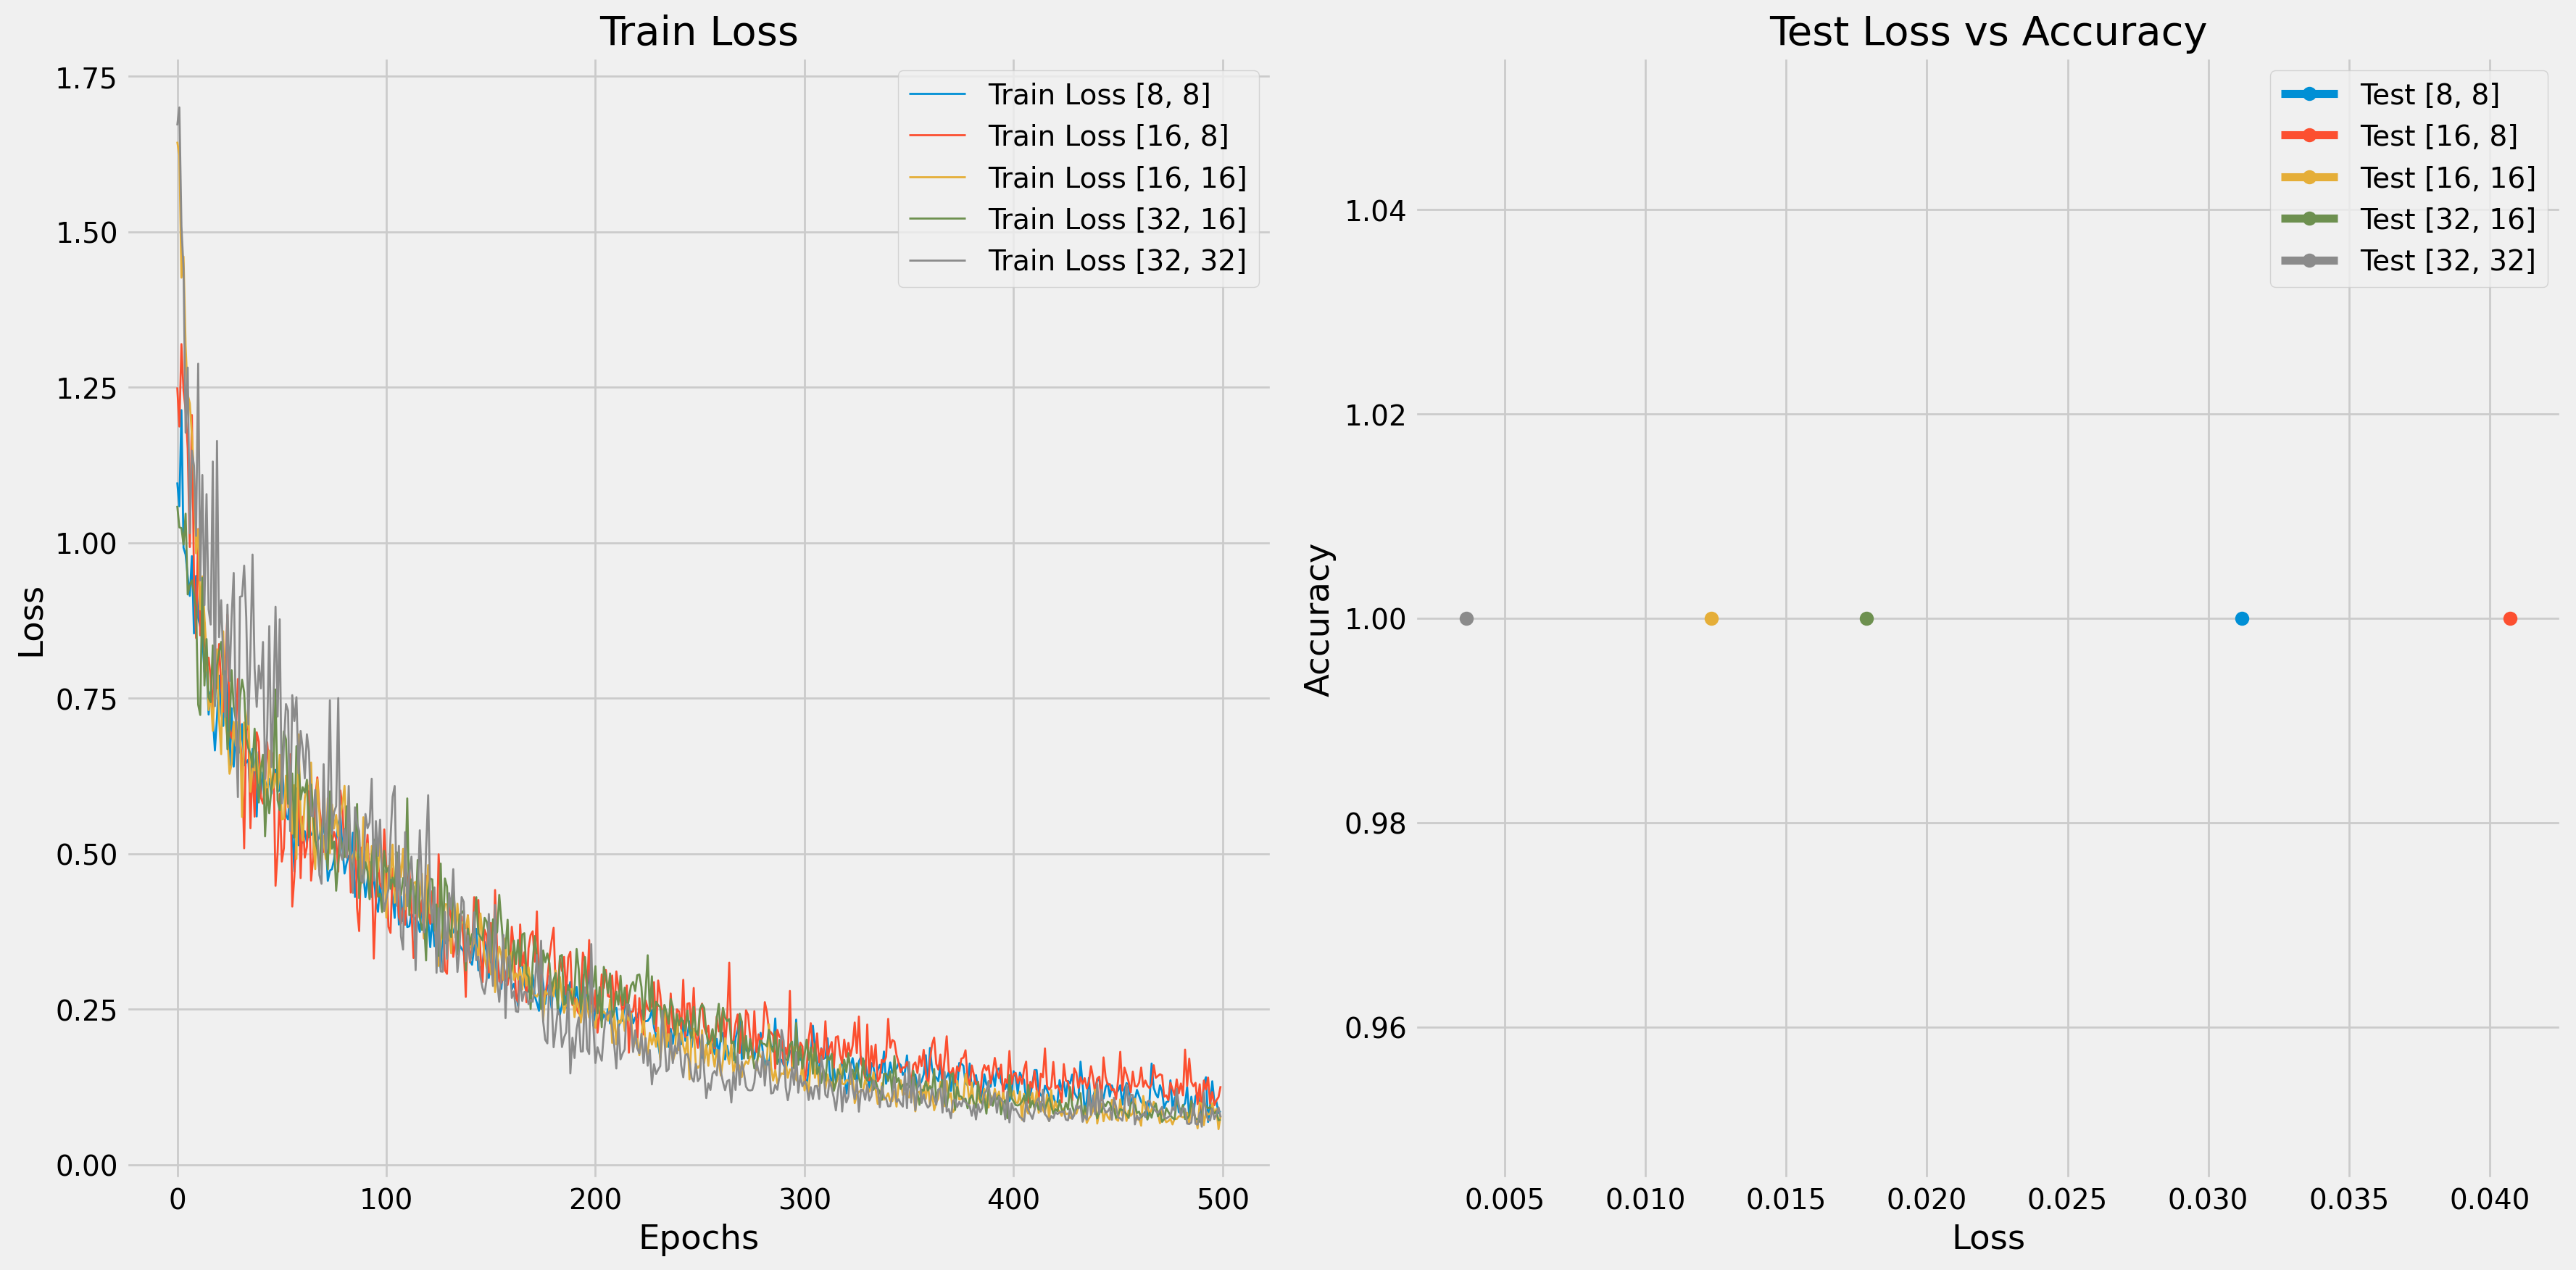

In [57]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([
    [8, 8],
    [16, 8],
    [16, 16],
    [32, 16],
    [32, 32],
    ]):
    architecture = [input_features] + i + [output_size]

    model = MLP(architecture, activation='tanh', dropout_p=0.1, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.01)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### learning rate

 20%|██        | 1/5 [00:02<00:10,  2.65s/it]

Early stopping na época 380


 40%|████      | 2/5 [00:04<00:07,  2.34s/it]

Early stopping na época 321


100%|██████████| 5/5 [00:14<00:00,  2.92s/it]


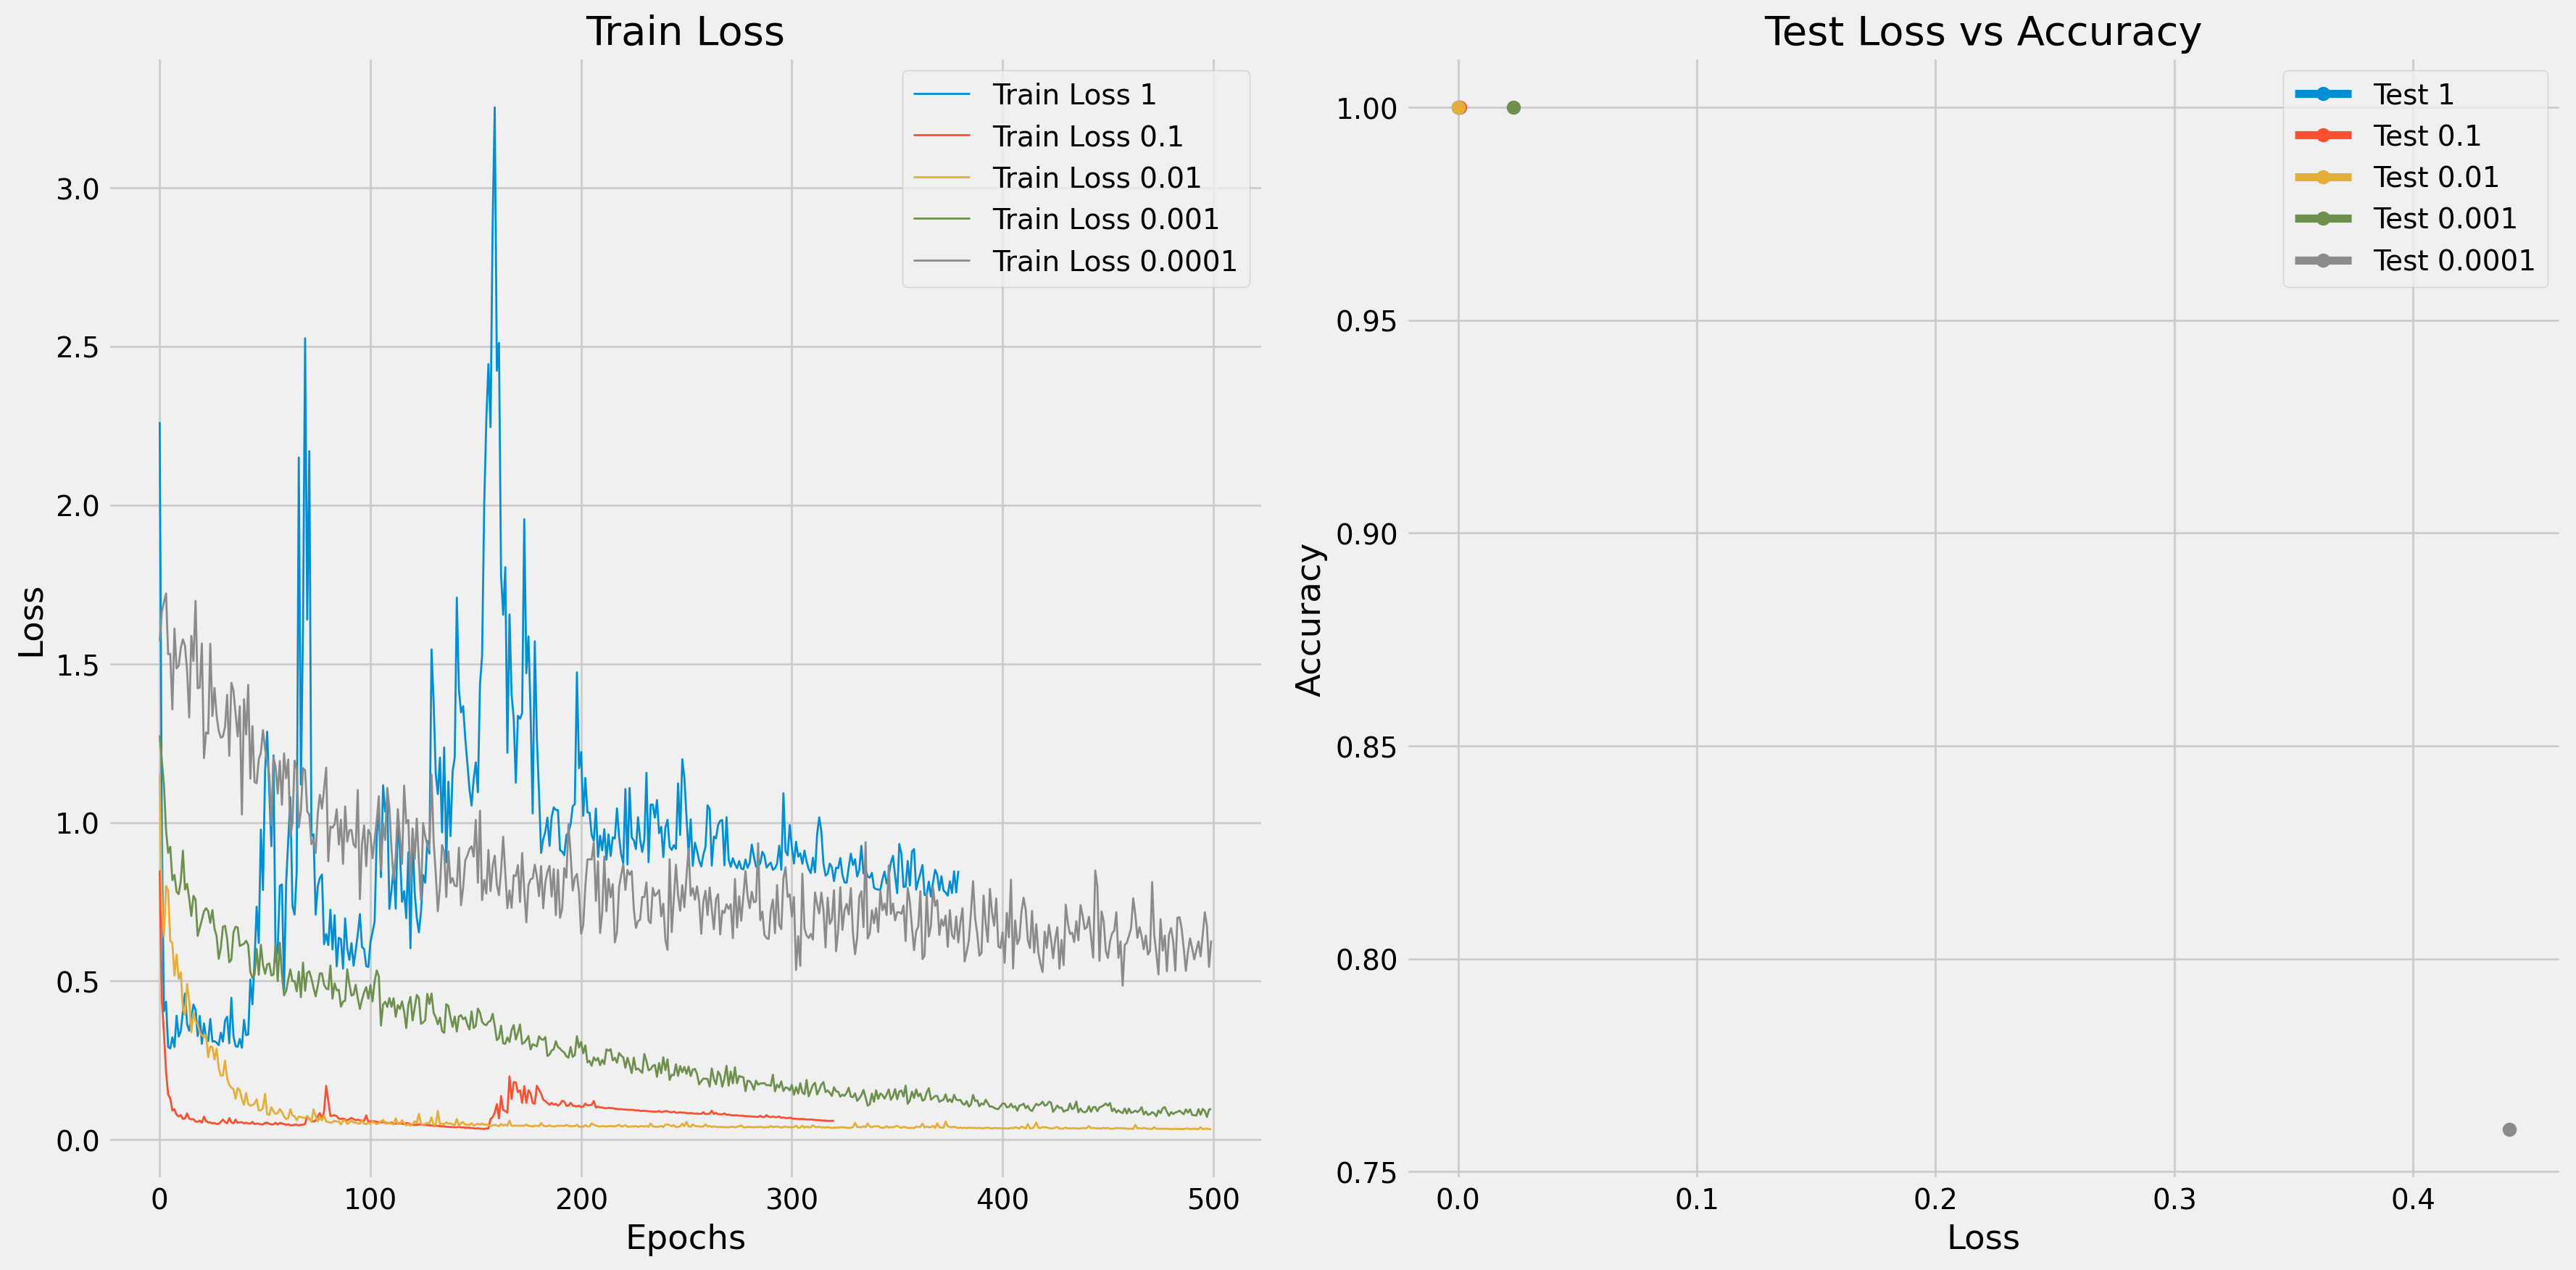

In [58]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]

    model = MLP(architecture, activation='tanh', dropout_p=0.1, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type='adam', lr=i, momentum=0.01)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### dropout

 20%|██        | 1/5 [00:02<00:10,  2.52s/it]

Early stopping na época 381


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


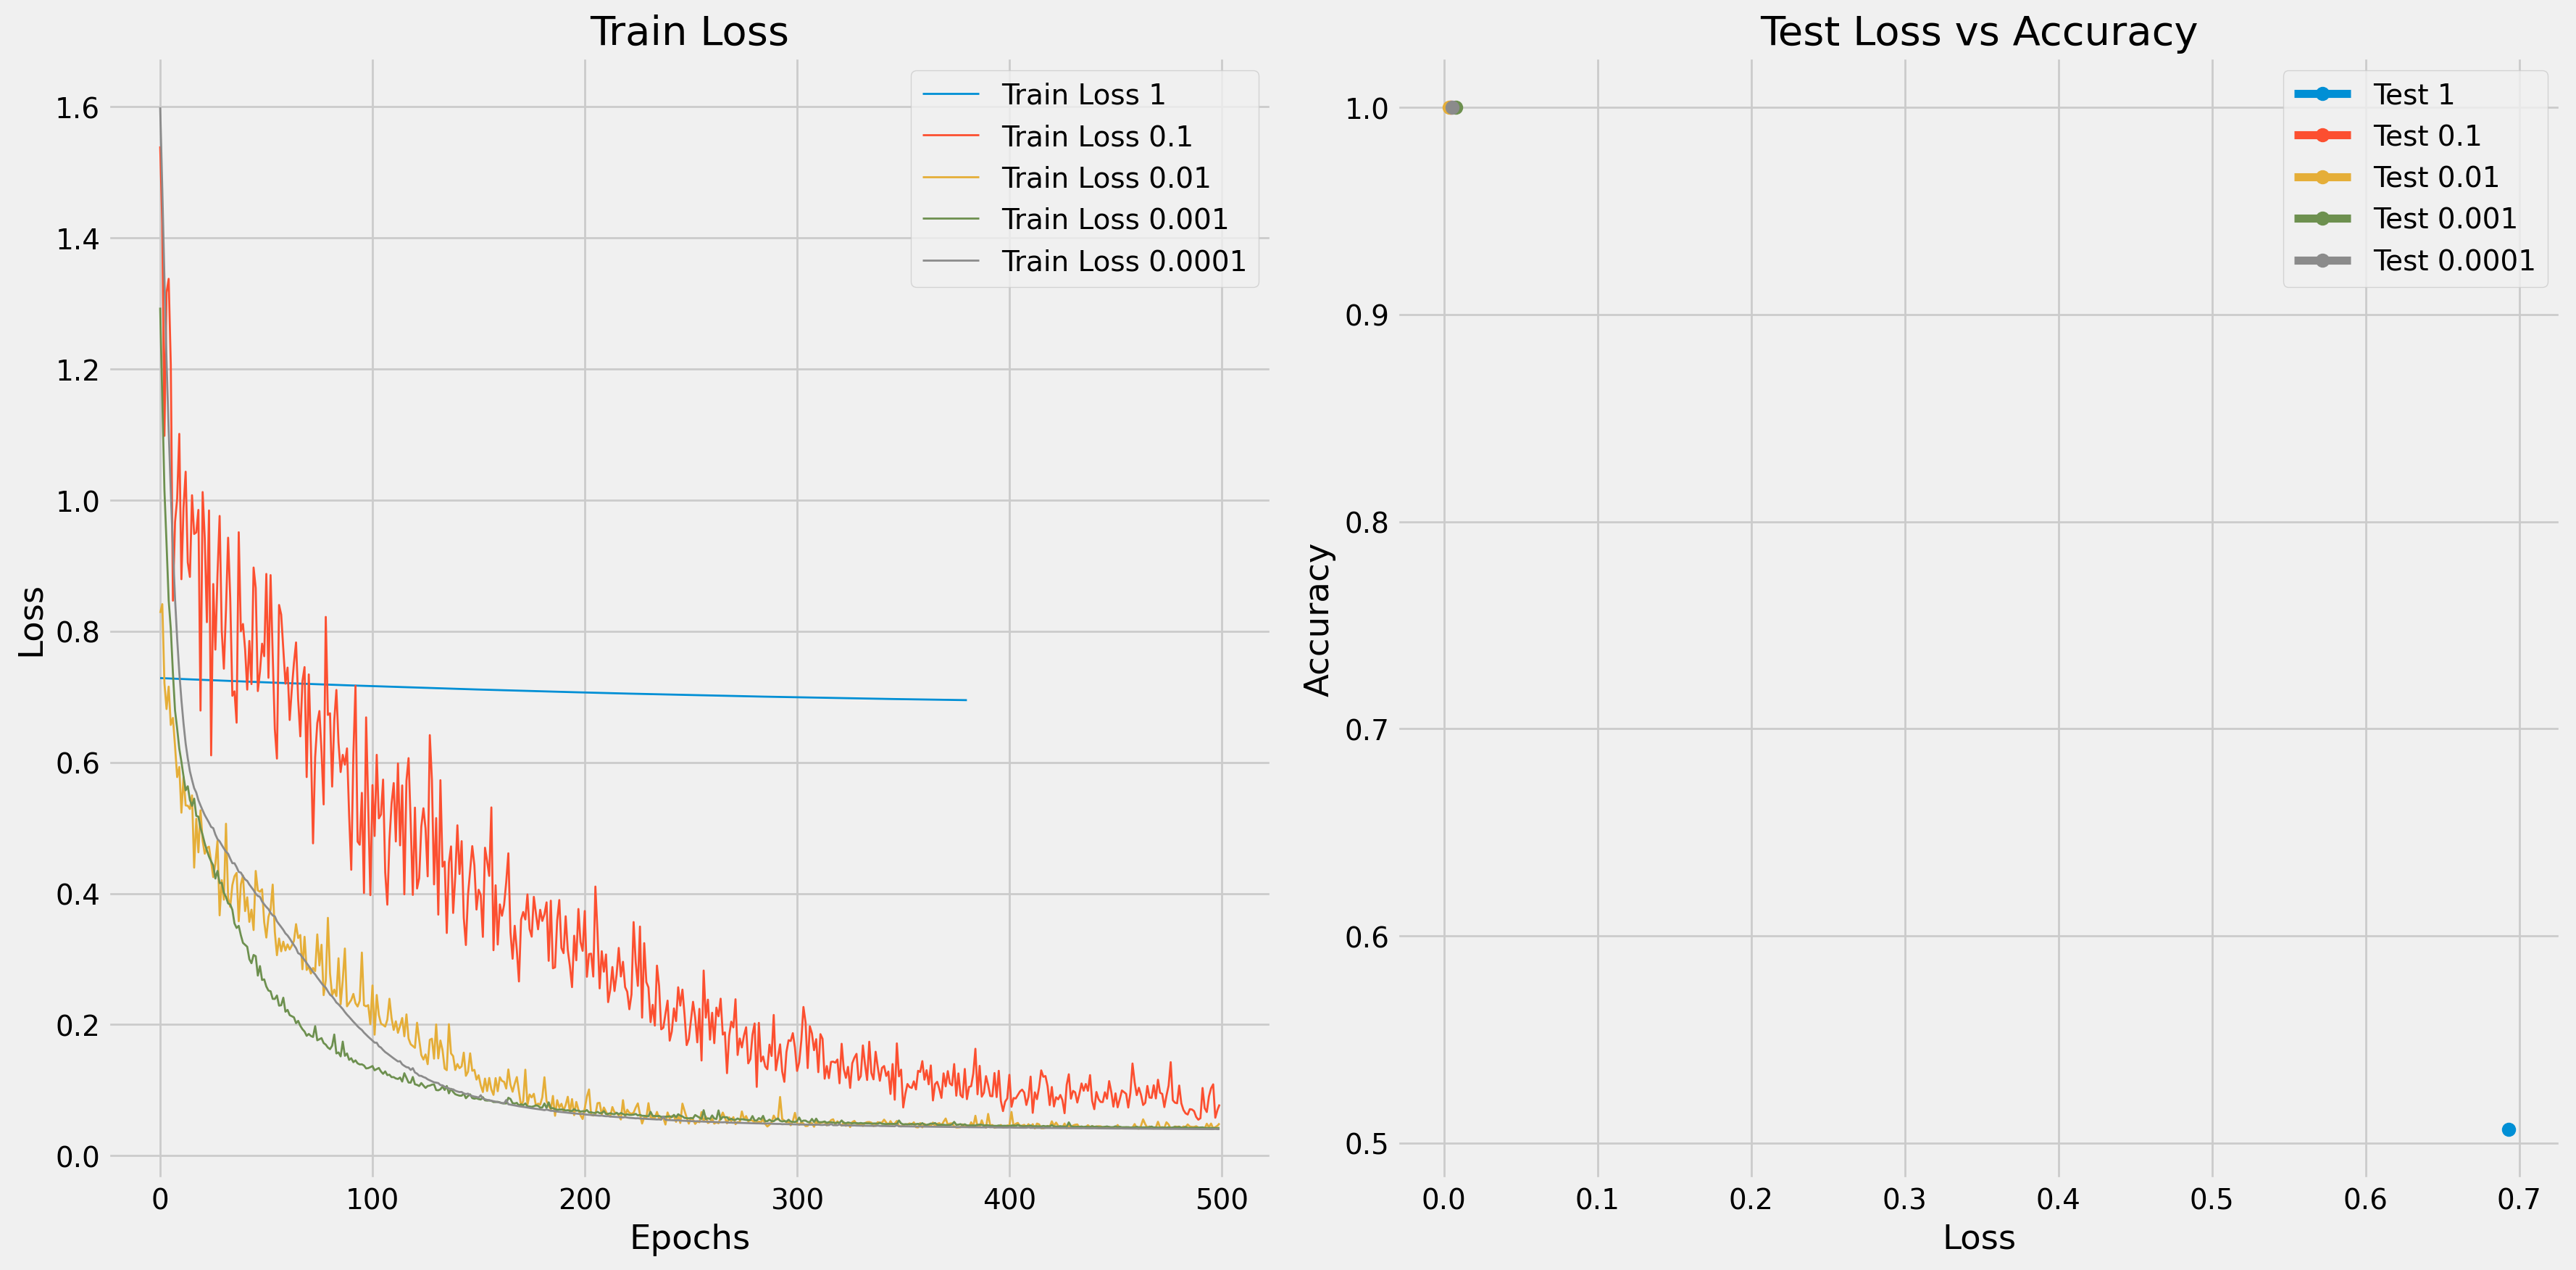

In [59]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]

    model = MLP(architecture, activation='tanh', dropout_p=i, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.01)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### momentum

100%|██████████| 5/5 [00:16<00:00,  3.27s/it]


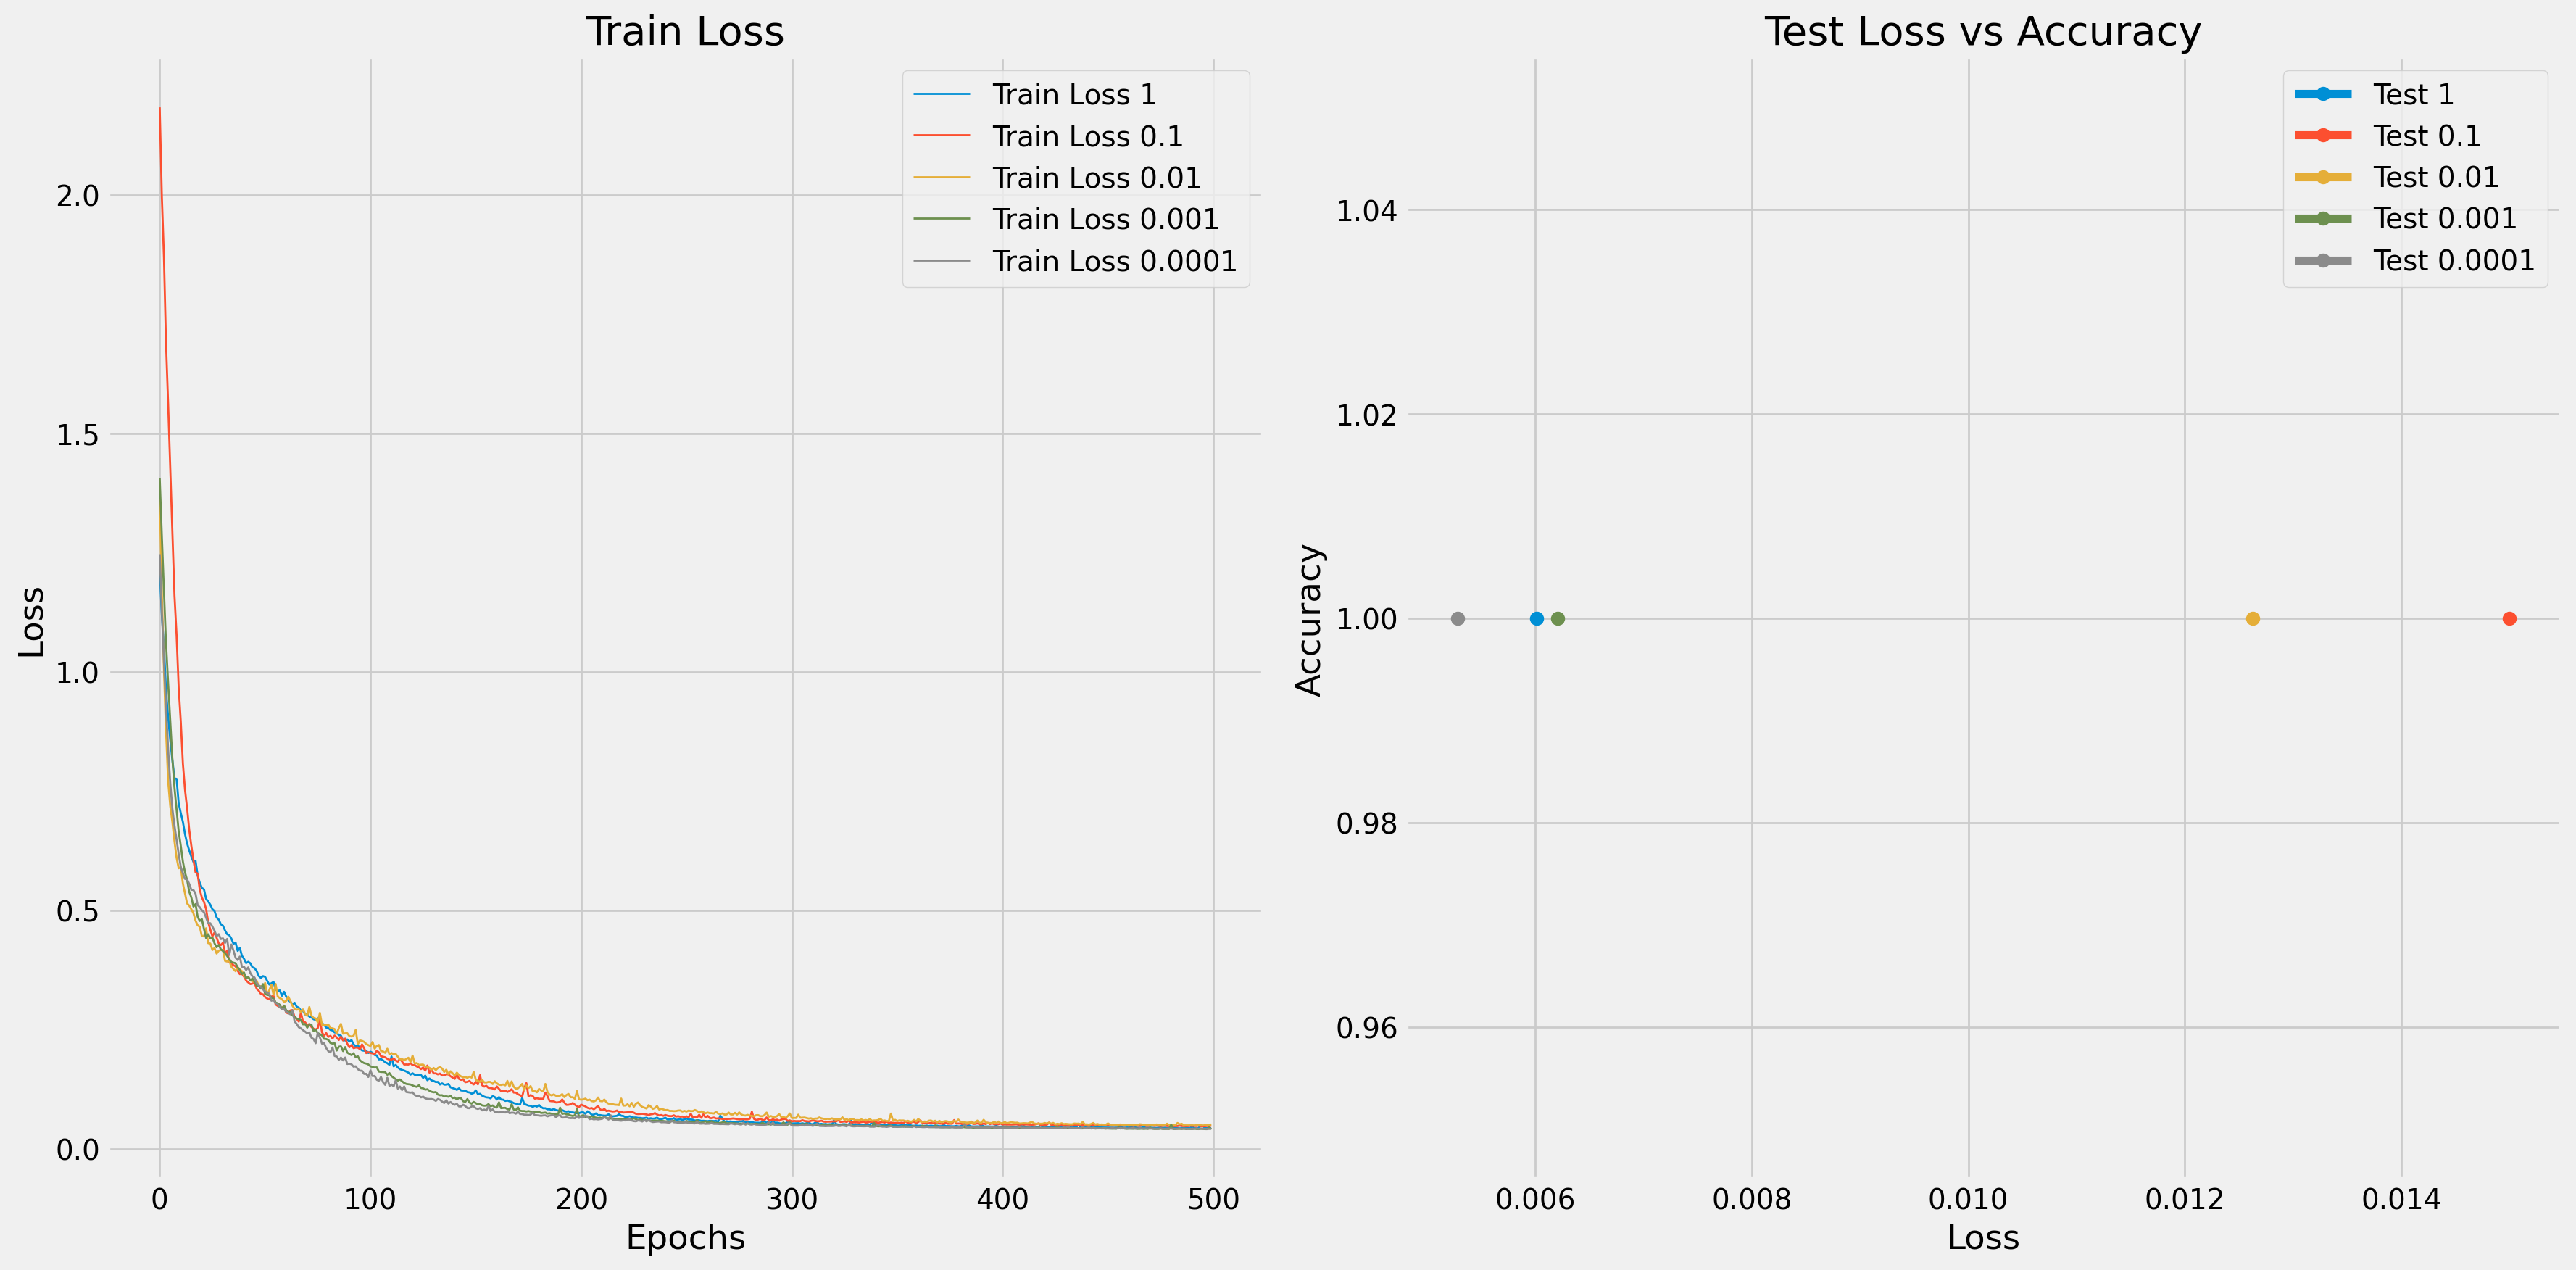

In [60]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]

    model = MLP(architecture, activation='tanh', dropout_p=0.001, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=i)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### regularization

 20%|██        | 1/5 [00:01<00:04,  1.20s/it]

Early stopping na época 179


 40%|████      | 2/5 [00:03<00:06,  2.09s/it]

Early stopping na época 411


100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


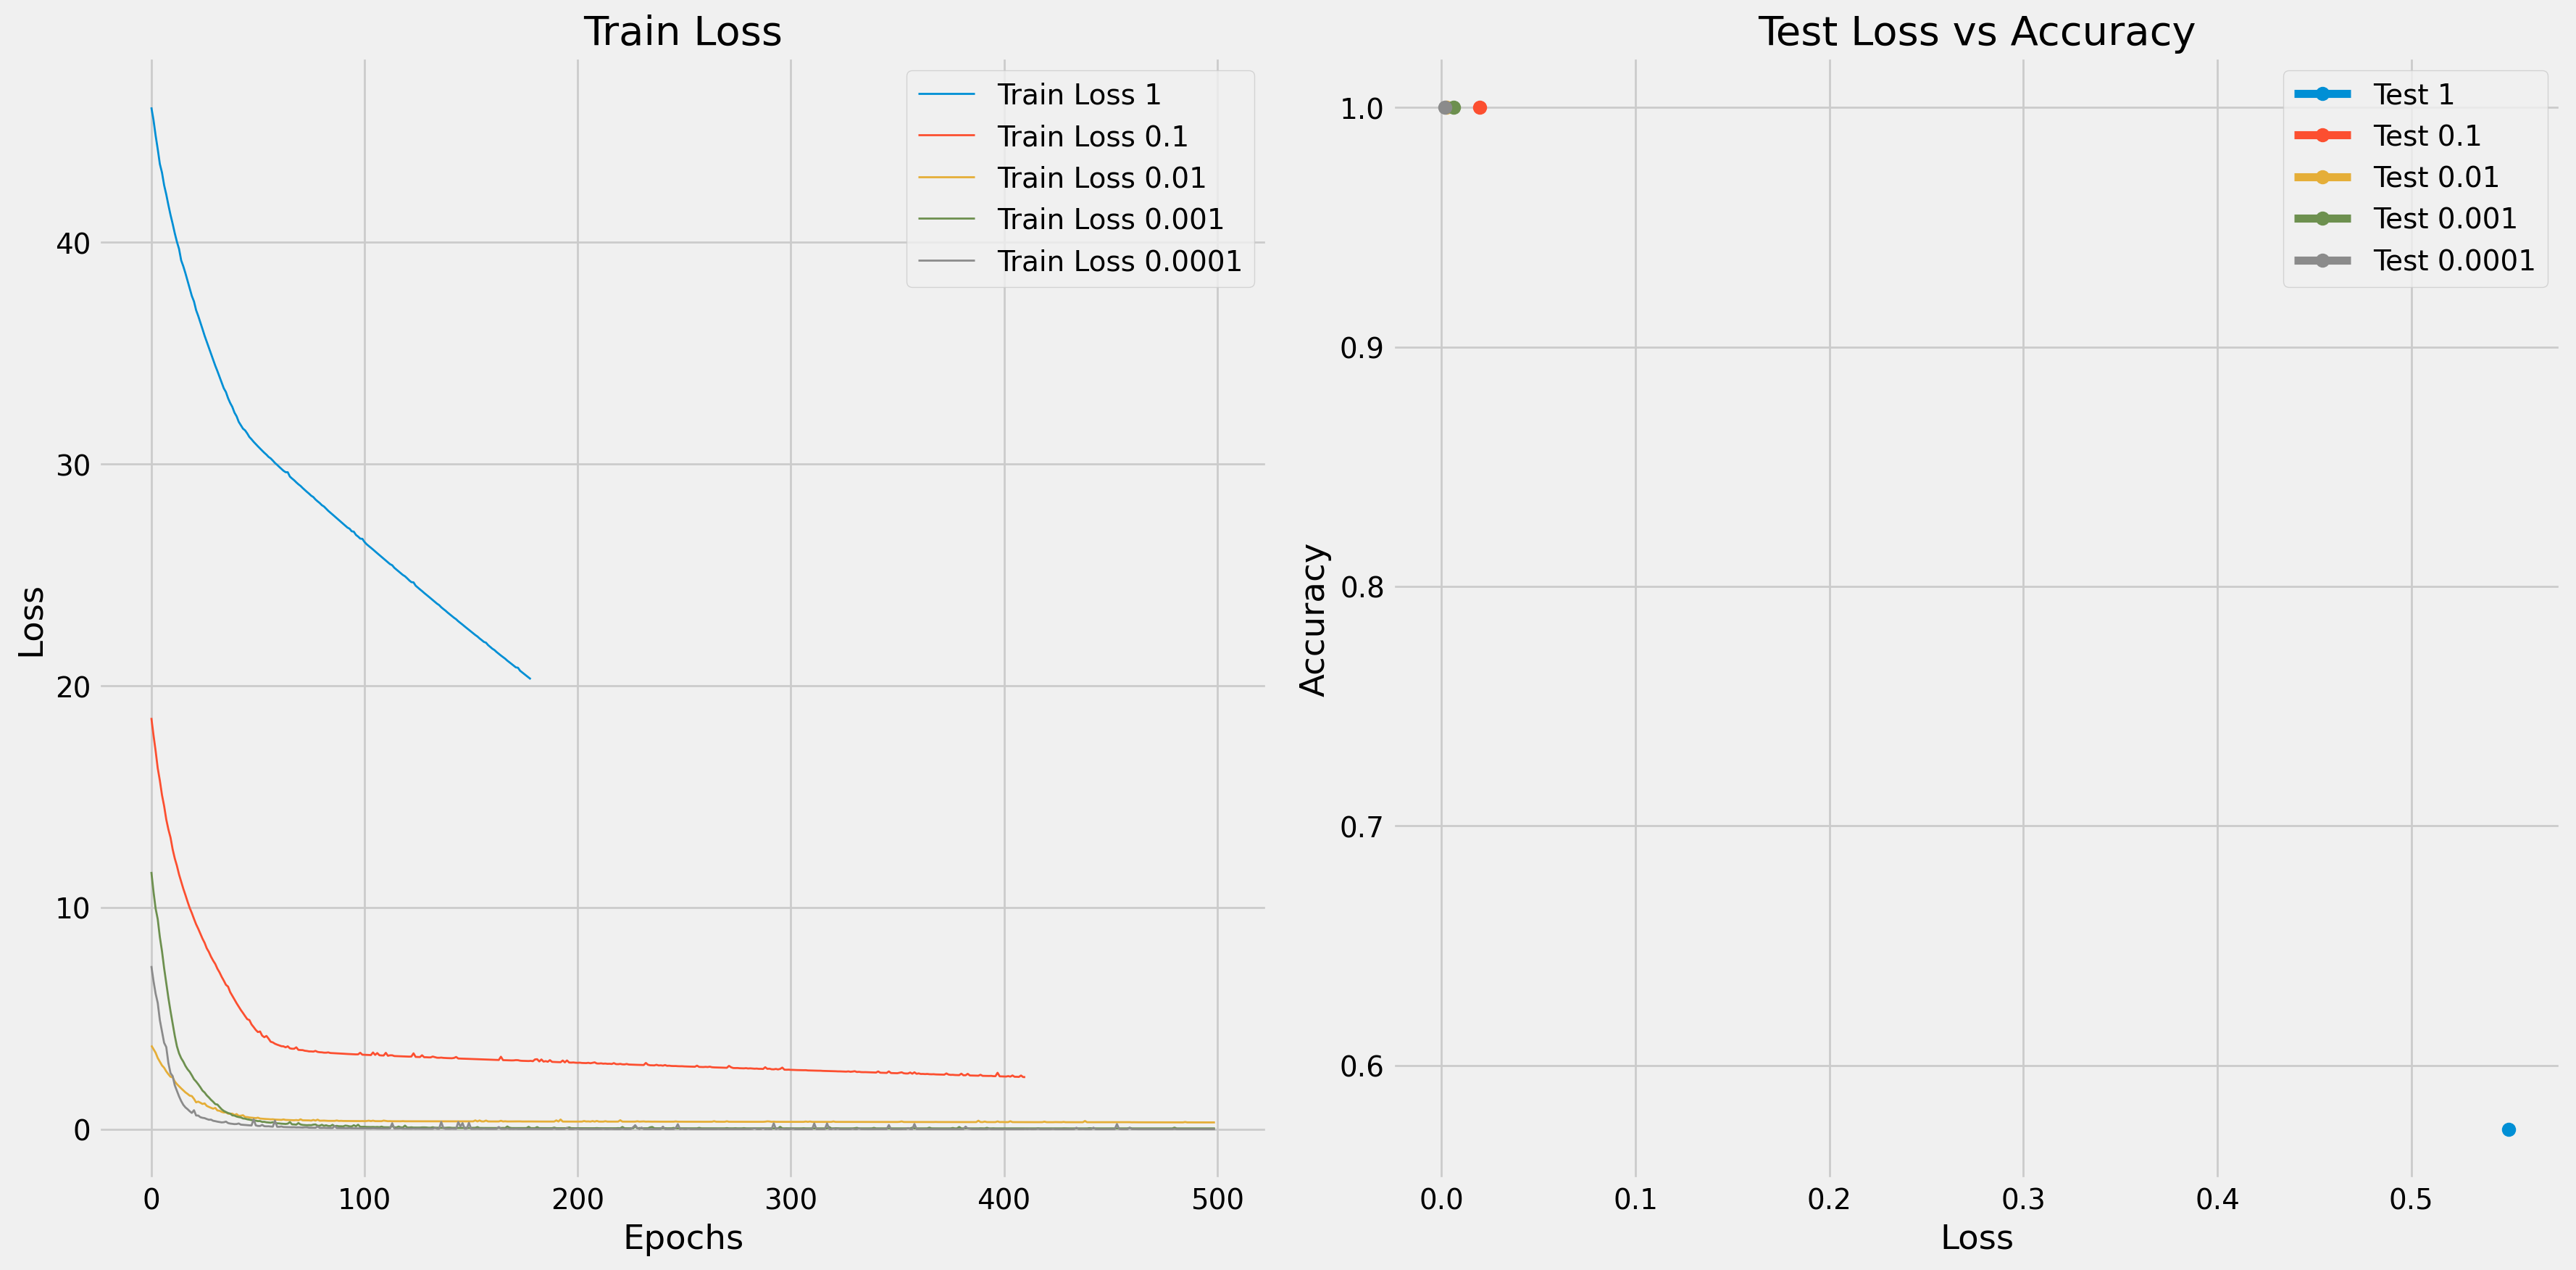

In [63]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm([1, 1e-1, 1e-2, 1e-3, 1e-4]):
    architecture = [input_features] + [32, 16] + [output_size]

    model = MLP(architecture, activation='relu', dropout_p=0.001, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.001)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = i,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### activation

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


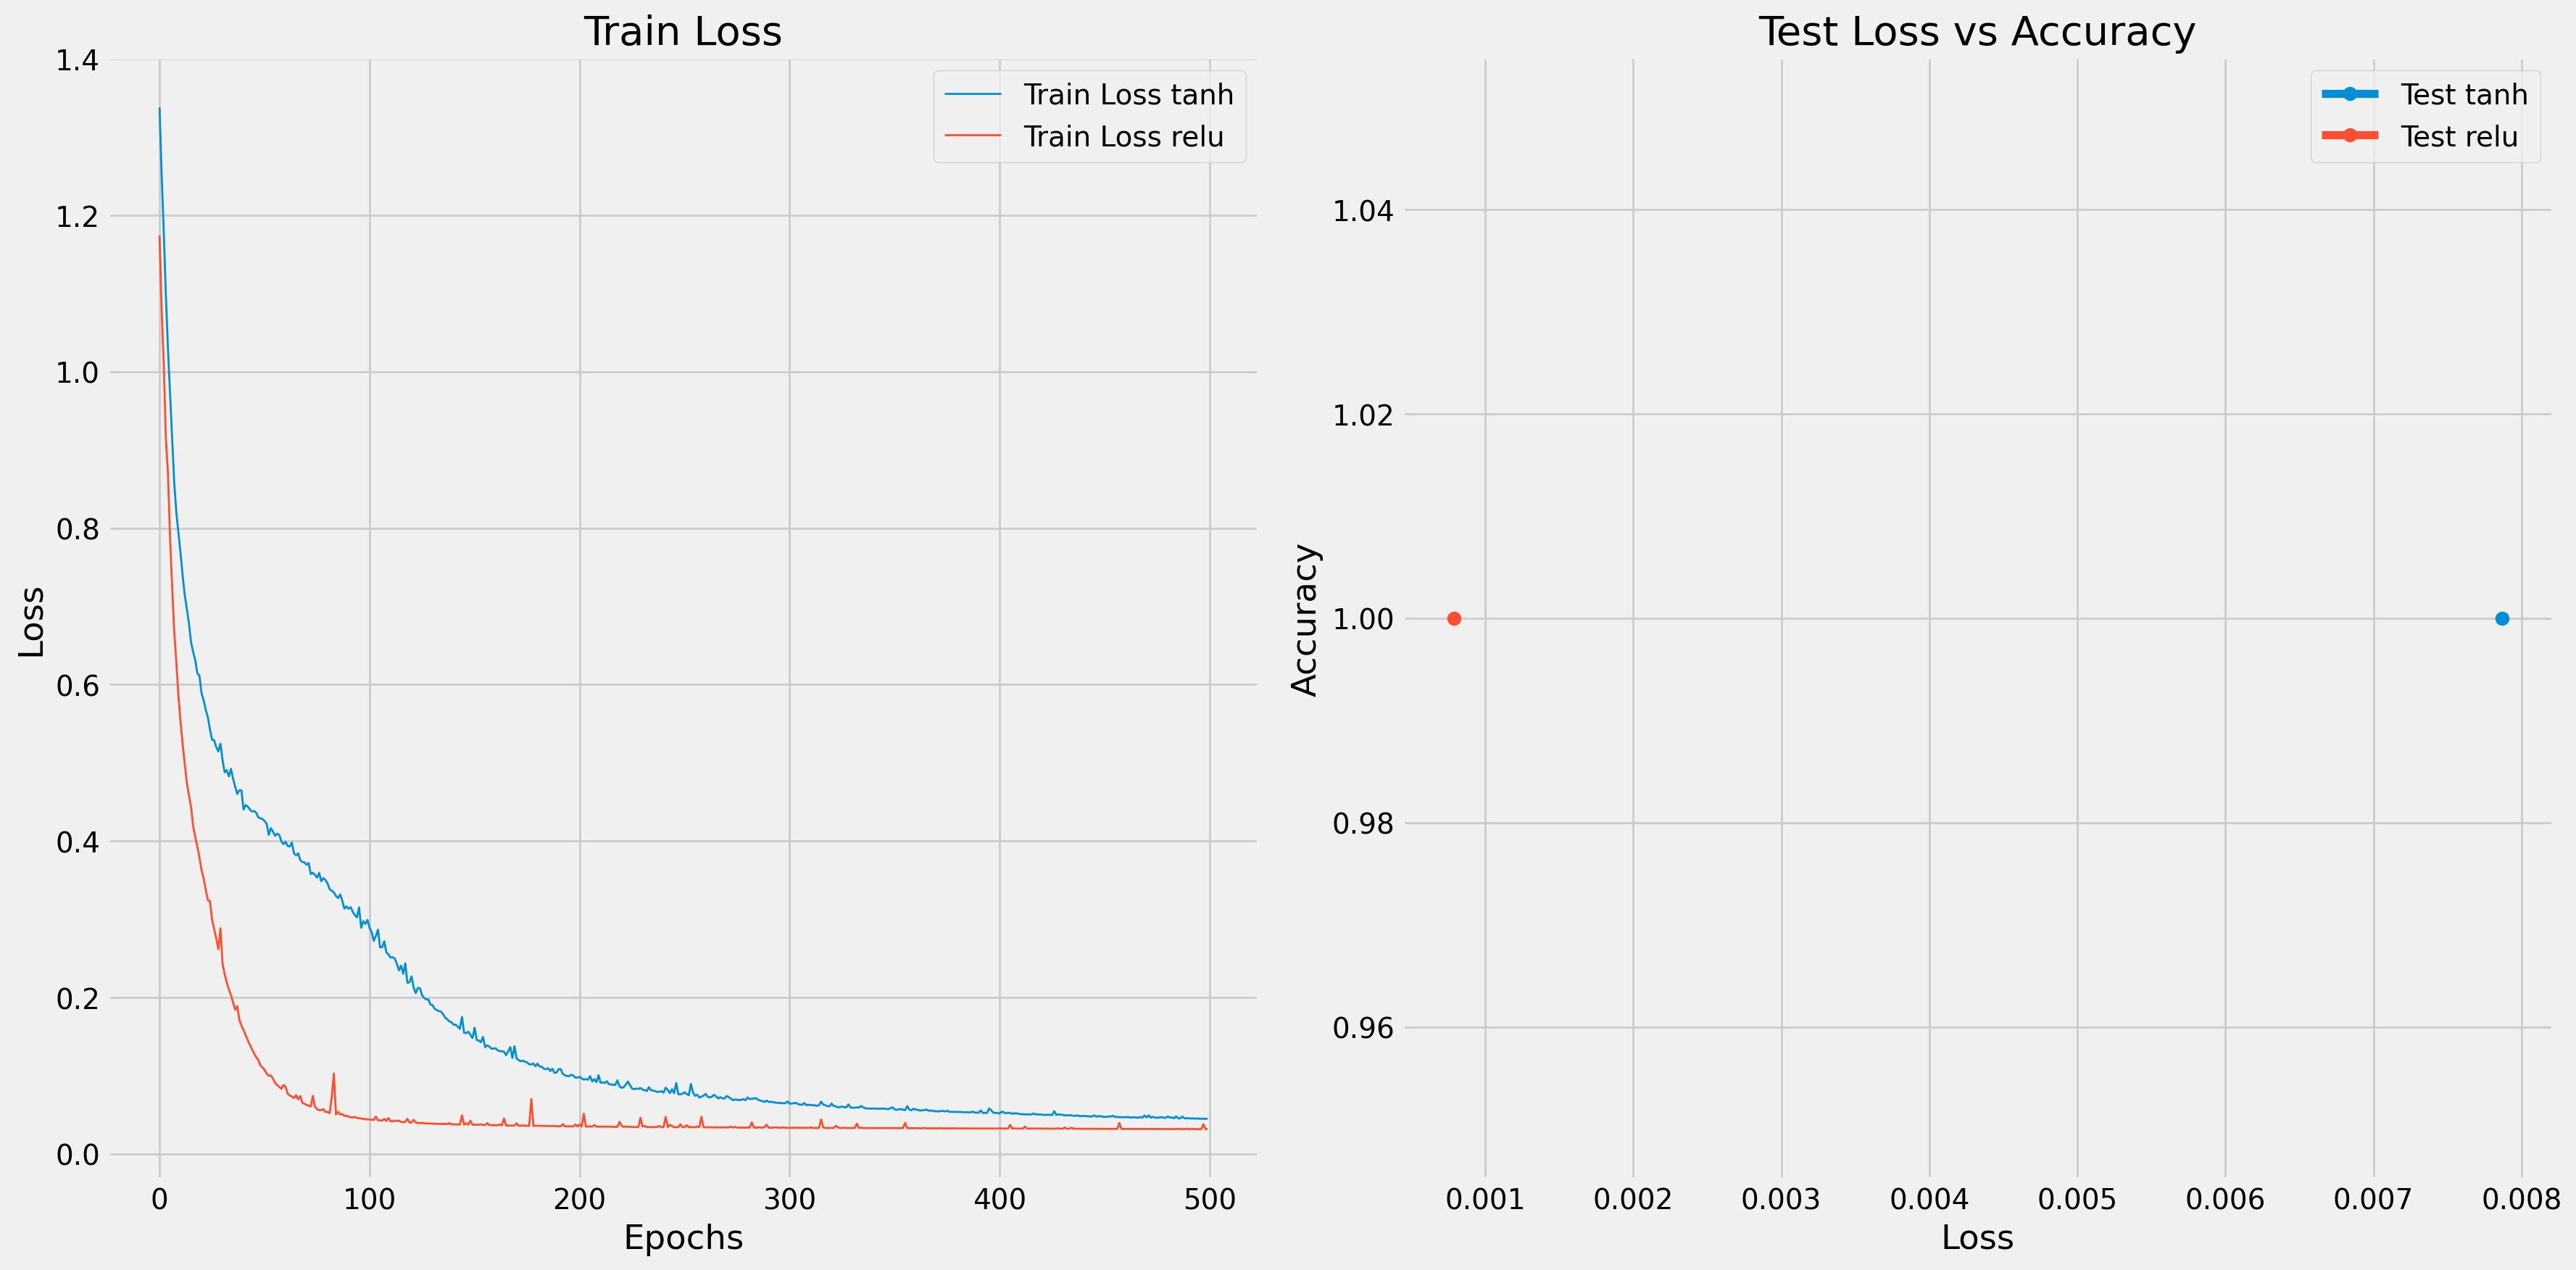

In [61]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm(['tanh', 'relu']):
    architecture = [input_features] + [32, 16] + [output_size]

    model = MLP(architecture, activation=i, dropout_p=0.001, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type='adam', lr=0.001, momentum=0.001)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

### optimizer

100%|██████████| 2/2 [00:06<00:00,  3.07s/it]


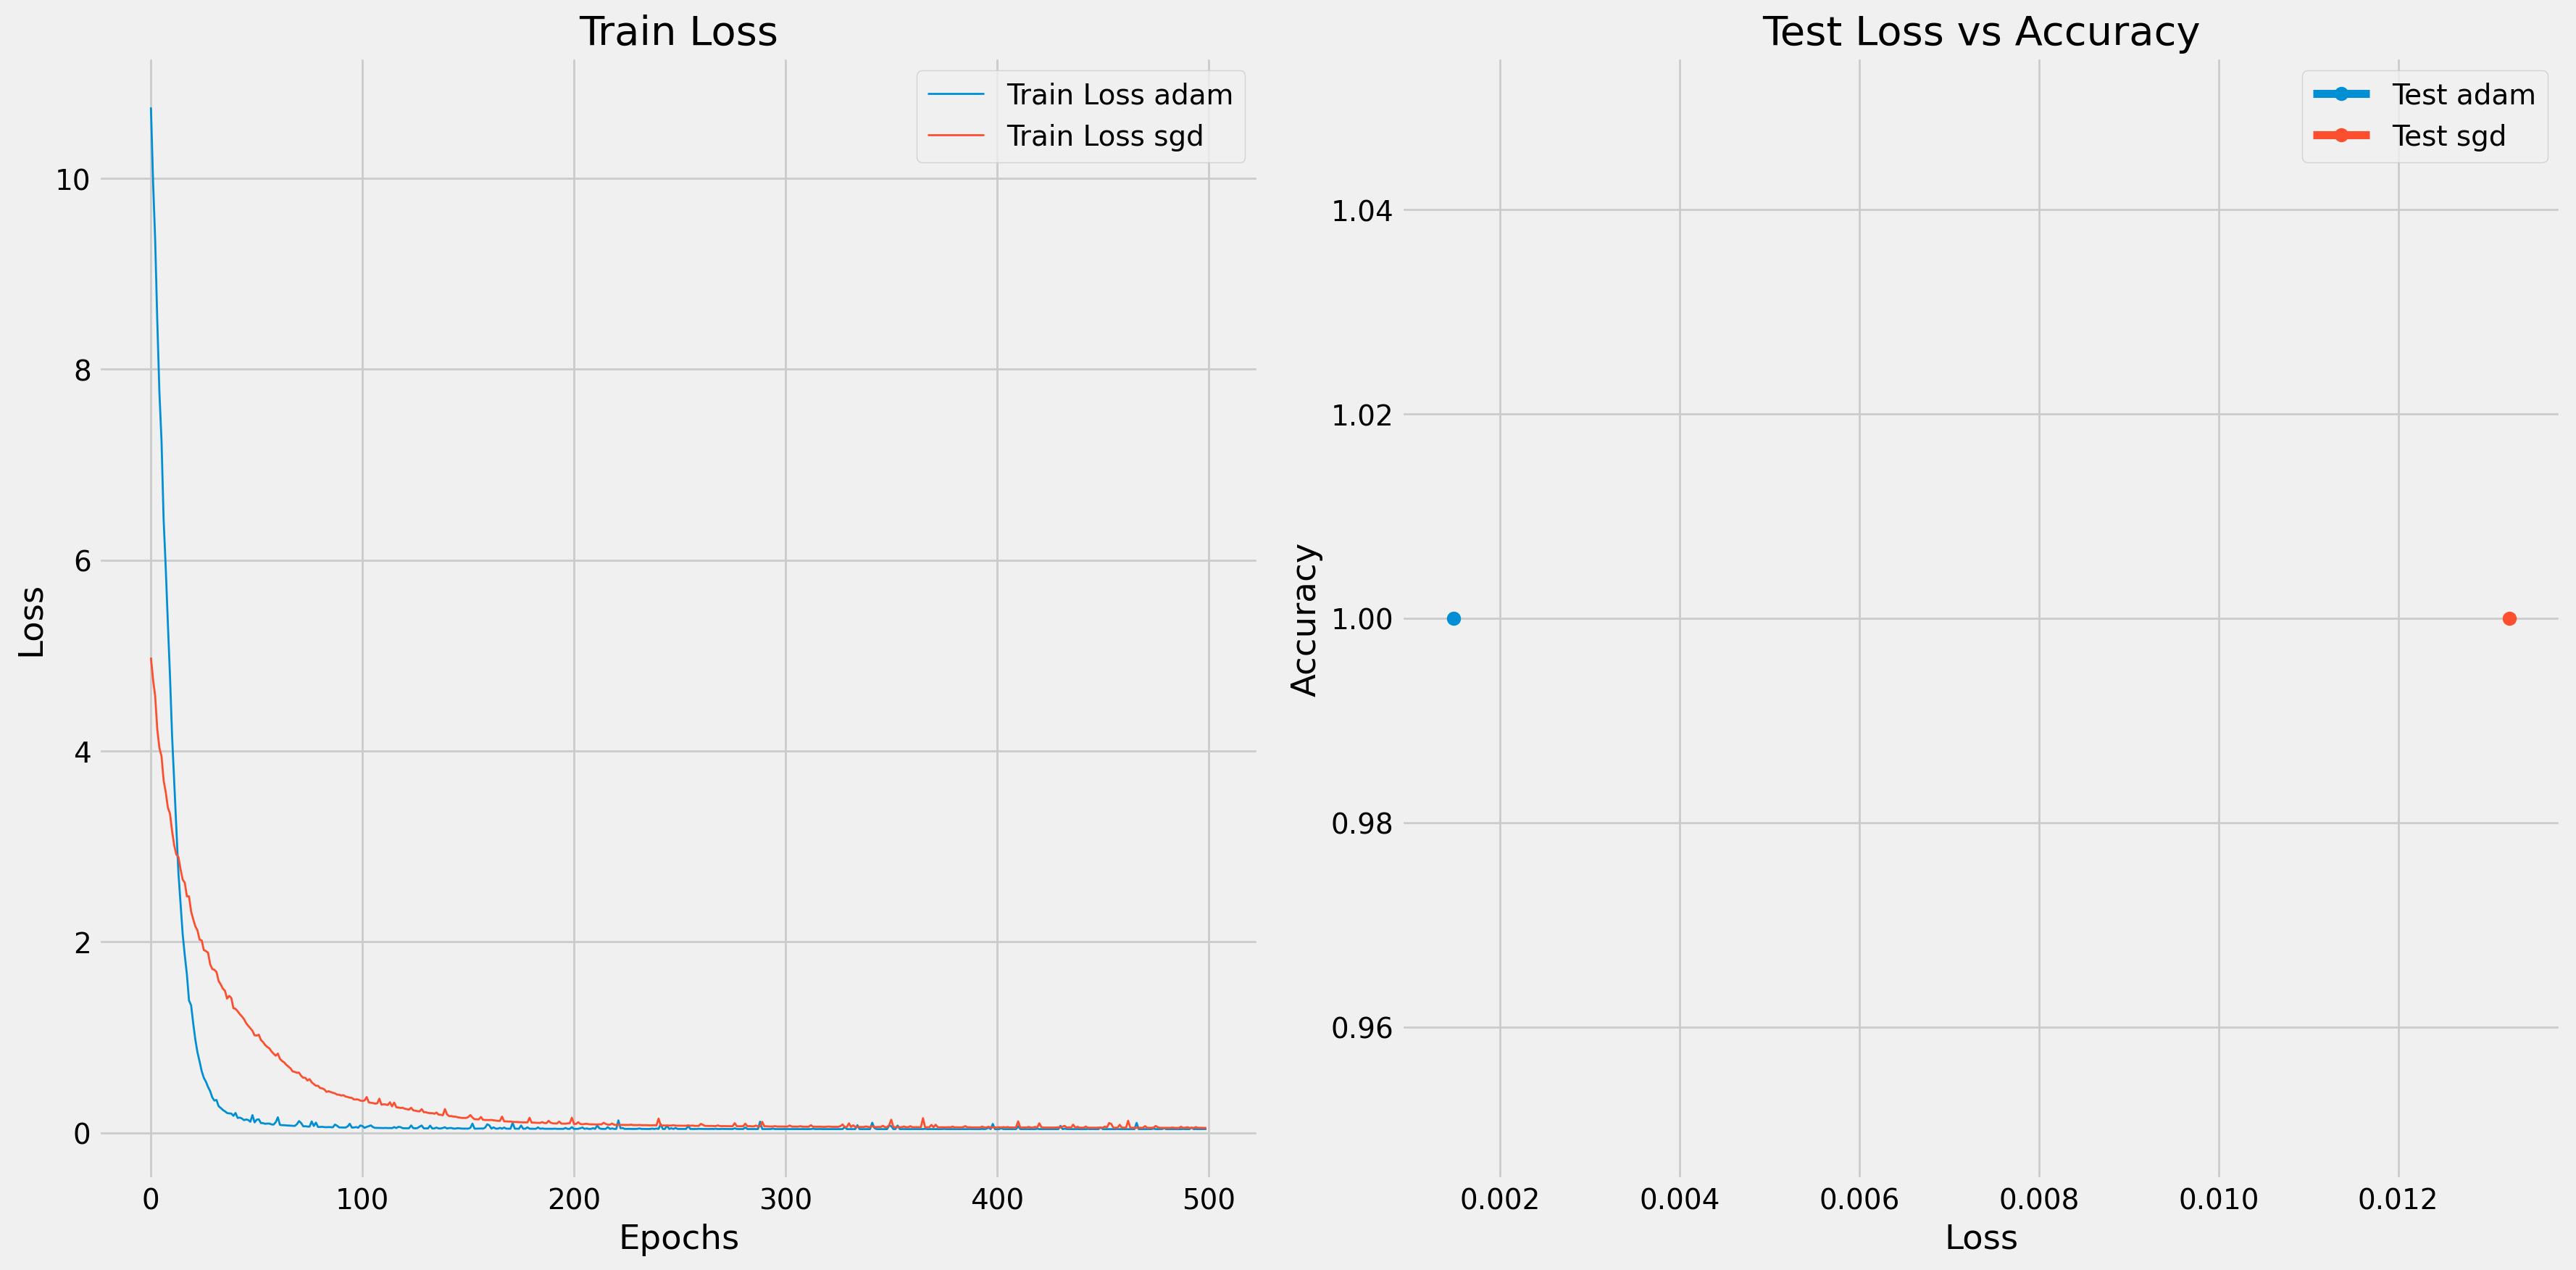

In [62]:
_, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in tqdm.tqdm(['adam', 'sgd']):
    architecture = [input_features] + [32, 16] + [output_size]

    model = MLP(architecture, activation='relu', dropout_p=0.001, use_l2=True)

    criterion = get_loss_function(task=task)

    optimizer = get_optimizer(model, optimizer_type=i, lr=0.001, momentum=0.001)

    history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        epochs = 500,
        patience = 100,
        l2_lambda = 0.001,
        task = task
    )
    test_loss, test_acc = evaluate_model(
        model, 
        test_loader, 
        criterion, 
        task = task
    )

    ax[0].plot(
        history['train_loss'], 
        label = f'Train Loss {i}',
        linewidth = 1
    )
    ax[1].plot(
        [test_loss],
        [test_acc],
        label = f'Test {i}',
        marker = 'o',
    )
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train Loss')
    ax[0].legend()
    ax[1].set_xlabel('Loss')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Loss vs Accuracy')
    ax[1].legend()
    plt.tight_layout()

.